In [1]:
import os
import sys
import time
import csv
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import scipy as sc
import pandas as pd

import aav.modeling as modeling
import aav.data_prep as data_prep
from sklearn.model_selection import train_test_split
import util

import aav.entropy_opt as entropy_opt
import aav.opt_analysis as opt_analysis

from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 16

import seaborn as sns
sns.set_style('darkgrid')

/home/clarafy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/clarafy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/clarafy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/clarafy/anaconda

In [2]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import tensorflow.keras.backend as K

config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': 40} ) 
sess = tf.Session(config=config) 
K.set_session(sess)

In [13]:
# confirming the data in /storage/akosua/aav_clean/data/counts is already filtered
# After this filtering, the pre- and post-libraries contained 46,049,235 and 45,306,265 reads, respectively
fnames = ['../aav/counts/old_nnk_pre_counts.csv', '../aav/counts/old_nnk_post_counts.csv']
for fname in fnames:
    with open(fname) as f:
        rdr = csv.reader(f)
        rdr.__next__()
        n_read = 0
        for row in rdr:
            n_read += int(float(row[1]))
    print(n_read)

46049235
45306265


## train predictive model

In [4]:
reload(data_prep)
data_df = data_prep.load_data('old_nnk', use_filtered=False)  # already filtered?

In [5]:
data_df

,index,seq,count_pre,count_post
0,0,*****WL,18.0,0.0
1,1,****DYC,1.0,0.0
2,2,****DYW,3.0,0.0
3,3,****EEC,1.0,0.0
4,4,****F*W,1.0,0.0
...,...,...,...,...
8552724,8557786,YYYYTNN,0.0,1.0
8552725,8557787,YYYYTRL,0.0,1.0
8552726,8557788,YYYYTTT,0.0,1.0
8552727,8557789,YYYYVYP,0.0,1.0


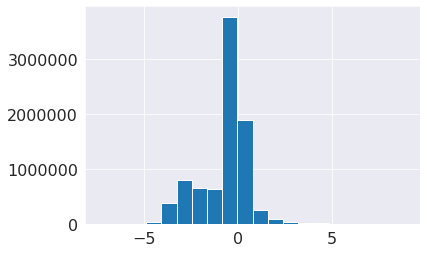

In [13]:
seqs, en_scores = data_prep.prepare_data(data_df)
train_idx, test_idx = train_test_split(range(len(seqs)), test_size=0.2, random_state=123) 
plt.hist(en_scores[:, 0], bins=20);

In [31]:
reload(modeling)
enc = data_prep.one_hot_encode
input_shape = data_prep.get_example_encoding(enc).shape
epochs = 1
batch_size = 100
hidden_size = 1000
weighted_loss = "True"

model = modeling.make_ann_model(input_shape, num_hid=2, hid_size=hidden_size, weighted_loss=weighted_loss)

train_gen = modeling.DataGenerator(seqs, en_scores, train_idx, enc, batch_size=batch_size, shuffle=True)
test_gen = modeling.DataGenerator(seqs, en_scores, test_idx, enc, batch_size=1000, shuffle=False)

history_callback = model.fit_generator(
    generator=train_gen, epochs=epochs, use_multiprocessing=False, workers=36, verbose=1
)
model.save('../aav/models/seed123_011022.npy')

68421/68421 [==============================] - 401s 6ms/step - loss: 1.3149


In [11]:
# try training ensemble to improve predictions
epochs = 10
batch_size = 100
hidden_size = 100
weighted_loss = True
n_seed = 5
savefile = "%s_ann_%s_%s" % ("old_nnk", hidden_size, "is")

enc = data_prep.one_hot_encode
input_shape = data_prep.get_example_encoding(enc).shape
train_gen = modeling.DataGenerator(seqs, en_scores, train_idx, enc, batch_size=batch_size, shuffle=True)
test_gen = modeling.DataGenerator(seqs, en_scores, test_idx, enc, batch_size=1000, shuffle=False)

for seed in range(n_seed, 2 * n_seed):
    t0 = time.time()
    model = modeling.make_ann_model(input_shape, num_hid=2, hid_size=hidden_size, weighted_loss=weighted_loss)
    history_callback = model.fit_generator(
        generator=train_gen, epochs=epochs, use_multiprocessing=False, workers=40, verbose=1
    )
    model.save('../aav/models/{}_seed{}.npy'.format(savefile, seed))
    print("{} seconds\n\n".format(time.time() - t0))

Epoch 1/10
68421/68421 [==============================] - 664s 10ms/step - loss: 1.0460
Epoch 2/10
68421/68421 [==============================] - 663s 10ms/step - loss: 0.9941
Epoch 3/10
68421/68421 [==============================] - 664s 10ms/step - loss: 0.9837
Epoch 4/10
68421/68421 [==============================] - 664s 10ms/step - loss: 0.9794
Epoch 5/10
68421/68421 [==============================] - 665s 10ms/step - loss: 0.9785
Epoch 6/10
68421/68421 [==============================] - 666s 10ms/step - loss: 0.9766
Epoch 7/10
68421/68421 [==============================] - 664s 10ms/step - loss: 0.9736
Epoch 8/10
68421/68421 [==============================] - 664s 10ms/step - loss: 0.9708
Epoch 9/10
68421/68421 [==============================] - 664s 10ms/step - loss: 0.9710
Epoch 10/10
68421/68421 [==============================] - 664s 10ms/step - loss: 0.9683
6643.229768514633 seconds




Epoch 1/10
68421/68421 [==============================] - 669s 10ms/step - loss: 1.0537
Epoch 2/10
68421/68421 [==============================] - 668s 10ms/step - loss: 1.0049
Epoch 3/10
68421/68421 [==============================] - 669s 10ms/step - loss: 0.9891
Epoch 4/10
68421/68421 [==============================] - 669s 10ms/step - loss: 0.9869
Epoch 5/10
68421/68421 [==============================] - 669s 10ms/step - loss: 0.9814
Epoch 6/10
68421/68421 [==============================] - 668s 10ms/step - loss: 0.9838
Epoch 7/10
68421/68421 [==============================] - 668s 10ms/step - loss: 0.9675
Epoch 8/10
68421/68421 [==============================] - 668s 10ms/step - loss: 0.9629
Epoch 9/10
68421/68421 [==============================] - 668s 10ms/step - loss: 0.9611
Epoch 10/10
68421/68421 [==============================] - 668s 10ms/step - loss: 0.9558
6684.164329051971 seconds




Epoch 1/10
68421/68421 [==============================] - 673s 10ms/step - loss: 1.0522
Epoch 2/10
68421/68421 [==============================] - 669s 10ms/step - loss: 1.0039
Epoch 3/10
68421/68421 [==============================] - 672s 10ms/step - loss: 0.9963
Epoch 4/10
68421/68421 [==============================] - 671s 10ms/step - loss: 0.9749
Epoch 5/10
68421/68421 [==============================] - 671s 10ms/step - loss: 0.9737
Epoch 6/10
68421/68421 [==============================] - 672s 10ms/step - loss: 0.9698
Epoch 7/10
68421/68421 [==============================] - 673s 10ms/step - loss: 0.9688
Epoch 8/10
68421/68421 [==============================] - 669s 10ms/step - loss: 0.9584
Epoch 9/10
68421/68421 [==============================] - 672s 10ms/step - loss: 0.9682
Epoch 10/10
68421/68421 [==============================] - 671s 10ms/step - loss: 0.9612
6714.76007604599 seconds




Epoch 1/10
68421/68421 [==============================] - 672s 10ms/step - loss: 1.0470
Epoch 2/10
68421/68421 [==============================] - 671s 10ms/step - loss: 1.0000
Epoch 3/10
68421/68421 [==============================] - 674s 10ms/step - loss: 1.0009
Epoch 4/10
68421/68421 [==============================] - 672s 10ms/step - loss: 0.9734
Epoch 5/10
68421/68421 [==============================] - 672s 10ms/step - loss: 0.9752
Epoch 6/10
68421/68421 [==============================] - 672s 10ms/step - loss: 0.9650
Epoch 7/10
68421/68421 [==============================] - 671s 10ms/step - loss: 0.9674
Epoch 8/10
68421/68421 [==============================] - 670s 10ms/step - loss: 0.9734
Epoch 9/10
68421/68421 [==============================] - 670s 10ms/step - loss: 0.9734
Epoch 10/10
68421/68421 [==============================] - 671s 10ms/step - loss: 0.9711
6717.282203197479 seconds




Epoch 1/10
68421/68421 [==============================] - 674s 10ms/step - loss: 1.0351
Epoch 2/10
68421/68421 [==============================] - 674s 10ms/step - loss: 1.0121
Epoch 3/10
68421/68421 [==============================] - 673s 10ms/step - loss: 0.9920
Epoch 4/10
68421/68421 [==============================] - 673s 10ms/step - loss: 0.9931
Epoch 5/10
68421/68421 [==============================] - 675s 10ms/step - loss: 0.9821
Epoch 6/10
68421/68421 [==============================] - 674s 10ms/step - loss: 0.9806
Epoch 7/10
68421/68421 [==============================] - 673s 10ms/step - loss: 0.9815
Epoch 8/10
68421/68421 [==============================] - 675s 10ms/step - loss: 0.9727
Epoch 9/10
68421/68421 [==============================] - 673s 10ms/step - loss: 0.9667
Epoch 10/10
68421/68421 [==============================] - 675s 10ms/step - loss: 0.9739
6739.143270969391 seconds




1710/1710 - 14s


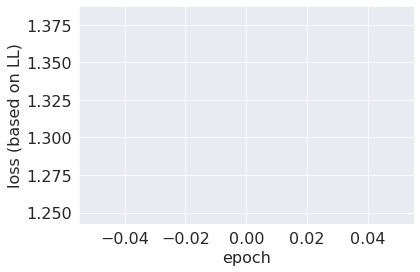

In [32]:
pred_n = model.predict_generator(test_gen, verbose=2).flatten()
loss_history = np.array(history_callback.history["loss"])

plt.plot(range(1), loss_history, linewidth=3);
plt.xlabel('epoch'); plt.ylabel('loss (based on LL)');

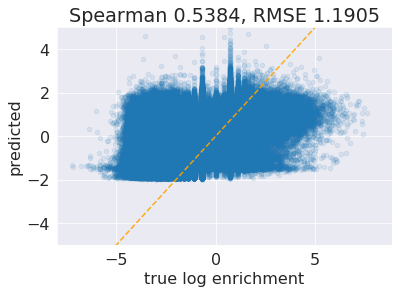

In [33]:
n_test = 1710000
ytest_n = en_scores[np.array(test_idx[: n_test]), 0]

plt.scatter(ytest_n, pred_n, alpha=0.1, s=20);
util.plot_xy(ytest_n, pred_n)
rho, p = sc.stats.spearmanr(ytest_n, pred_n)
rmse = np.sqrt(np.mean(np.square(ytest_n - pred_n)))

plt.ylim([-5, 5]);
plt.title('Spearman {:.4f}, RMSE {:.4f}'.format(rho, rmse));
plt.xlabel('true log enrichment'); plt.ylabel('predicted');

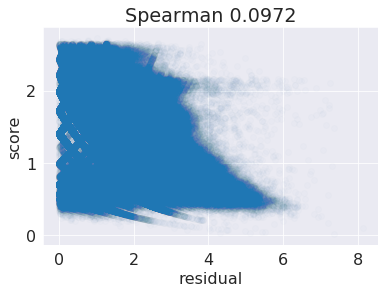

In [34]:
# playing around with heuristic score
err_n = np.abs(ytest_n - pred_n)
score_n = 1 / np.exp(0.5 * pred_n)
rho, p = sc.stats.spearmanr(err_n, score_n)

plt.scatter(err_n, score_n, alpha=0.01);
plt.title('Spearman {:.4f}'.format(rho))
plt.xlabel('residual'); plt.ylabel('score');

## prediction with ensemble

In [6]:
# prediction with ensemble
seqs, en_scores = data_prep.prepare_data(data_df)
enc = data_prep.one_hot_encode
input_shape = data_prep.get_example_encoding(enc).shape
d = np.load('../aav/models/500000_idx.npz')
test_idx = d['test_idx']
test_gen = modeling.DataGenerator(seqs, en_scores, test_idx, enc, batch_size=1000, shuffle=False)

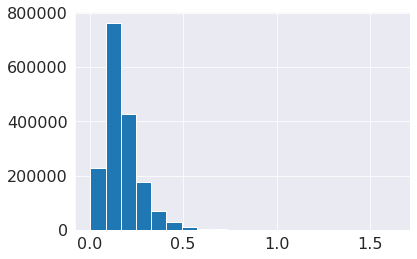

In [30]:
std_n = np.std(pred_sxn[: 5], axis=0)
plt.hist(std_n, bins=20);

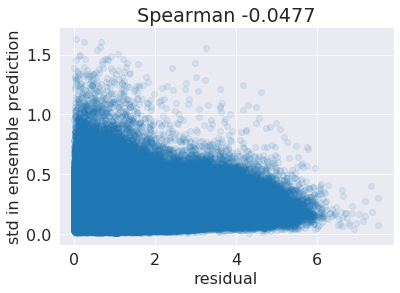

In [31]:
err_n = np.abs(ytest_n - pred_n)
rho, p = sc.stats.spearmanr(err_n, std_n)
plt.scatter(err_n, std_n, alpha=0.1);
plt.title('Spearman {:.4f}'.format(rho))

plt.xlabel('residual'); plt.ylabel('std in ensemble prediction');

## constrained maximum entropy

In [91]:
# D2 and D3 libraries correspond to lambda = 0.15, 0.3, where exp(1 / lambda)
theta0 = np.random.randn(21, 4)
enc = data_prep.one_hot_encode
l = 0.1
learning_rate = 0.01
niter = 2000
n_samples = 1000

t0 = time.time()
theta_opt, fx_opt, H_opt = entropy_opt.opt_theta_entropy_sgd(
    theta0, model, enc, entropy_reg=l, learning_rate=learning_rate, n_samples=n_samples, niter=niter,
    print_every=100, aa=False)
print(time.time() - t0)

iter fx H
0 -0.5148343 12.60526037817275
100 -0.28206074 12.797732593985122
200 -0.12507719 12.935701897779044
300 0.021747606 13.037241877468842
400 0.1783815 13.10185979379854
500 0.2968463 13.140586065375764
600 0.48668116 13.152214593383423
700 0.5031119 13.144608974469314
800 0.64063376 13.129882107112989
900 0.758275 13.112207458231548
1000 0.7914189 13.086191175413767
1100 0.82026935 13.060150874360065
1200 0.95441455 13.011668669902289
1300 0.9335003 12.983785502962068
1400 0.95864475 12.941126074196657
1500 1.0557859 12.897571829456238
1600 1.0993587 12.862717188962742
1700 1.1282489 12.826276442091835
1800 1.1311768 12.78664307500717
1900 1.229139 12.754765247272141
288.50389099121094


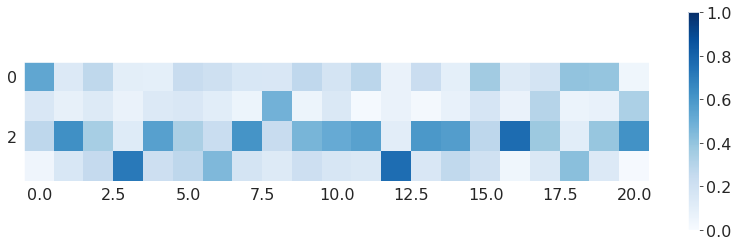

In [92]:
plt.figure(figsize=(14, 4));
theta_21x4 = np.exp(theta_opt)
theta_21x4 = theta_21x4 / np.sum(theta_21x4, axis=1, keepdims=True)
plt.imshow(theta_21x4.T, vmin=0, vmax=1, cmap='Blues');
plt.grid(None);
plt.colorbar();

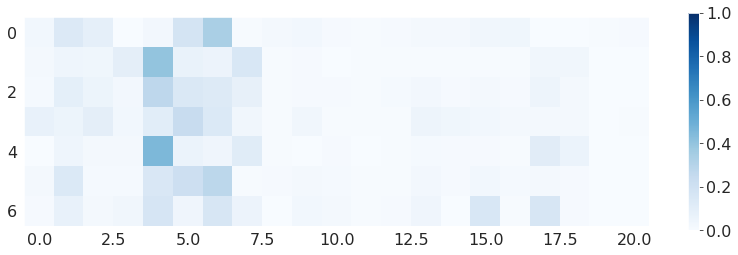

In [93]:
plt.figure(figsize=(14, 4));
theta_21x7 = opt_analysis.aa_probs_from_nuc_probs(theta_21x4)
plt.imshow(aatheta_21x7.T, vmin=0, vmax=1, cmap='Blues');
plt.grid(None);
plt.colorbar();

## trade-off curve for sanity checking and picking lambda

In [3]:
reload(entropy_opt)
model_path = '../aav/models/seed123_010722.npy'
savefile = '../aav/models/maxent_seed123.npy'
min_lambda = 0.1
max_lambda = 0.3
lr = 0.01
n_iter = 10000
n_sample = 1000

lambdas = np.linspace(min_lambda, max_lambda, 5)
model = keras.models.load_model(model_path)
enc = data_prep.one_hot_encode

results = {}
results['meta'] = {
    'model_path': model_path,
    'encoding': "is",
    'num_iter': n_iter,
    'num_samples': n_sample,
    'learning_rate': lr
}

entropy_opt.run_lambda_set(
    results, savefile, lambdas, model, enc, learning_rate=lr, niter=n_iter, n_samples=n_sample,
    aa=False, random_start=True
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
lambda = 0.1
iter fx EPD obj
0 -0.15971646 6.110923314319742 2.151117665232228
100 0.04216568 6.116735807151338 2.365087641932199
200 0.25362784 6.107455358046587 2.580598229542238
300 0.3770735 6.084802521631159 2.7019693939103933
400 0.5842788 6.050581797358245 2.9018949391274247
500 0.71563977 6.009501888490611 3.0221703017357022
600 0.7882349 5.963850977745567 3.083257150370238
700 0.88837826 5.913876726651752 3.1694023617697886
800 0.9608474 5.863873775608049 3.2288855194608477
900 1.0203365 5.816437338567594 3.275345059338929
1000 1.1194865 5.770717368106807 3.362173089765814


2700 1.2437989 5.9983721821642915 4.893010757356188
2800 1.2917789 5.987099872418027 4.935397458992112
2900 1.2112031 5.978072965991514 4.852052030418408
3000 1.3011445 5.969743418664481 4.937890038142982
3100 1.2314804 5.958622373810997 4.862886673074482
3200 1.3350483 5.949986248641219 4.9624845200505145
3300 1.3338519 5.942427874962117 4.957649142251503
3400 1.3084358 5.932647468773612 4.928221356715049
3500 1.3669113 5.9247233813063644 4.9836361558040805
3600 1.3528491 5.918782703293269 4.968076817483487
3700 1.3613105 5.905605457645531 4.971084745476027
3800 1.3694676 5.895353375335361 4.9751536871565705
3900 1.4500468 5.88055063626873 5.048631668580907
4000 1.401454 5.874279059883298 4.9971171018623295
4100 1.4077425 5.866842427831186 5.00134132343584
4200 1.4017886 5.854351746049441 4.990058322915718
4300 1.4632862 5.849702941495333 5.050976097100209
4400 1.4694277 5.8423355932357195 5.053452807425359
4500 1.5078952 5.832985557736107 5.088828240626505
4600 1.4799211 5.8204515736

KeyboardInterrupt: 

In [27]:
d = np.load(savefile, allow_pickle=True)
for lmbda in lambdas:
    theta = d.item()[lmbda][2]
    e_dist = opt_analysis.calc_expected_pairwise_dist_from_theta(theta, calc_aa=True, input_is_aa=False)
    print(lmbda, e_dist)

1.0751276414352766


## training fixed model

In [18]:
n = len([seq for seq in seqs if "*" in seq])
print(n, n / len(seqs))

1546932 0.18086998898246395


In [ ]:
reload(data_prep)
data_df = data_prep.load_data('old_nnk', use_filtered=False)  # already filtered?
seqs, en_scores = data_prep.prepare_data(data_df)
n_seq = len(seqs)
n_test = 500000

np.random.seed(123456)
shuffle_idx = np.random.permutation(n_seq)
train_idx, test_idx = shuffle_idx[: -n_test], shuffle_idx[n_seq - n_test :]
train_idx, cal_idx = train_idx[: -n_test], train_idx[-n_test :]
print(train_idx.size, cal_idx.size, test_idx.size)
# train_idx, test_idx = train_test_split(range(len(seqs)), test_size=0.2, random_state=123) 
# train_idx, cal_idx = train_test_split(train_idx, test_size=0.2, random_state=456) 
plt.hist(en_scores[:, 0], bins=20);

In [7]:
np.savez('../aav/models/500000_idx.npz', train_idx=train_idx, test_idx=test_idx, cal_idx=cal_idx)

In [4]:
d = np.load('../aav/models/500000_idx.npz')
train_idx = d['train_idx']
test_idx = d['test_idx']
cal_idx = d['cal_idx']
seqs, en_scores = data_prep.prepare_data(data_df)


In [5]:
reload(modeling)
enc = data_prep.one_hot_encode
input_shape = data_prep.get_example_encoding(enc).shape
epochs = 10
batch_size = 100
hidden_size = 100
enc_str = 'is'

train_gen = modeling.DataGenerator(seqs, en_scores, train_idx, enc, batch_size=batch_size, shuffle=True)
test_gen = modeling.DataGenerator(seqs, en_scores, test_idx, enc, batch_size=1000, shuffle=False)

for seed in range(5):
    t0 = time.time()
    model = modeling.make_ann_model(input_shape, num_hid=2, hid_size=hidden_size, weighted_loss=True)
    history_callback = model.fit_generator(
        generator=train_gen, epochs=epochs, use_multiprocessing=False, workers=36, verbose=1
    )
    model.save('../aav/models/nn{}_{}_seed{}_011222.npy'.format(hidden_size, enc_str, seed))
    print("{} s".format(time.time() - t0))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
75527/75527 [==============================] - 683s 9ms/step - loss: 1.0278
Epoch 2/10
75527/75527 [==============================] - 689s 9ms/step - loss: 0.9891
Epoch 3/10
75527/75527 [==============================] - 686s 9ms/step - loss: 0.9737
Epoch 4/10
75527/75527 [==============================] - 687s 9ms/step - loss: 0.9714
Epoch 5/10
75527/75527 [==============================] - 686s 9ms/step - loss: 0.9689
Epoch 6/10
75527/75527 [==============================] - 686s 9ms/step - loss: 0.9620
Epoch 7/10
75527/75527 [==============================] - 691s 9ms/step - loss: 0.9665
Epoch 8/10
75527/75527 [==============================] - 691s 9ms/step - loss: 0.9642
Epoch 9/10
75527/75527 [==============================] - 692s 9ms/step - loss: 0.9610
Epoch 10/10
75527/75527 [=================